## 1. Introduction.

This Capstone is based on data from a World Health Organization data set containing data about life expectancy and things that contribute to it. The data is sorted by country and year.

I am comparing the life expectancy of people in countries categorized as "developing" to that of people in countries categorized as "developed."

I will be focusing on data from countries in years where they were in a similar range of gross domestic product (GDP) and expenditure on health as a percentage of GDP per capita. This will allow for a more significant comparison by minimizing the differences in other key factors.

## 2. Hypothesis

H_o: The distribution of life expectancy is the same for people in developing countries as people in developed countries.

H_a: The distribution of life expectancy is different for people in developing countries than people in developed countries.

## 3. Data 

The data comes from [Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who?select=Life+Expectancy+Data.csv) and contains World Health Organization life expectancy data for 193 countries from 2000-2015.

161 of these countries are considered "developing," while only 32 are considered "developed." This, along with the much higher rate of alcohol consumption in the developed countries made it challenging to balance sample size with simlarity in the additionally identified relevant variables.

In [ ]:
#Setting up environment

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from scipy import stats
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
sns.set(style="darkgrid")

In [ ]:
#Google SDK authorization to dowload csv file with from a Google Drive id

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Fetching csv file from shareable Google Drive file location

downloaded = drive.CreateFile({'id':"1zQcKcWLnum2If3SBhTTKHwigABTLc0sh"})
downloaded.GetContentFile('life_expectancy_data.csv')

In [ ]:
df = pd.read_csv("life_expectancy_data.csv") 

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
#Cleaning up the column names to make them easier to work with in Python environment

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#Making new column to correct name of column that was different than description from source of dataset and contained an extra space typo
#and contained a "-" which confused some code

df['thinness_10to19_years'] = df['thinness__1-19_years']
df['thinness_5to9_years'] = df['thinness_5-9_years']

#Checking the column names post-cleanup
#(there should be no capitalization, and underscores should have replaced any spaces)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under-five_deaths                2938 non-null   int64  
 12  polio               

In [ ]:
#identifying nulls

null_rows = df[df.isnull().any(axis=1)]
null_rows.head(10)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,thinness_10to19_years,thinness_5to9_years
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,59.5,24,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4,6.0,5.8
44,Algeria,2003,Developing,71.7,146.0,20,0.34,25.018523,NaN,15374,47.0,23,87.0,3.60,87.0,0.1,294.335560,3243514.0,6.3,6.1,0.663,11.5,6.3,6.1
45,Algeria,2002,Developing,71.6,145.0,20,0.36,148.511984,NaN,5862,46.1,23,86.0,3.73,86.0,0.1,1774.336730,3199546.0,6.3,6.2,0.653,11.1,6.3,6.2
46,Algeria,2001,Developing,71.4,145.0,20,0.23,147.986071,NaN,2686,45.3,24,89.0,3.84,89.0,0.1,1732.857979,31592153.0,6.4,6.3,0.644,10.9,6.4,6.3
47,Algeria,2000,Developing,71.3,145.0,21,0.25,154.455944,NaN,0,44.4,25,86.0,3.49,86.0,0.1,1757.177970,3118366.0,6.5,6.4,0.636,10.7,6.5,6.4
48,Angola,2015,Developing,52.4,335.0,66,NaN,0.000000,64.0,118,23.3,98,7.0,NaN,64.0,1.9,3695.793748,2785935.0,8.3,8.2,0.531,11.4,8.3,8.2
57,Angola,2006,Developing,47.7,381.0,90,5.84,25.086888,NaN,765,18.2,143,36.0,4.54,34.0,2.5,262.415149,2262399.0,9.8,9.7,0.439,7.2,9.8,9.7
58,Angola,2005,Developing,47.4,382.0,92,5.04,98.191451,NaN,258,17.7,148,39.0,4.10,38.0,2.6,1443.991929,19552542.0,1.0,9.9,0.426,6.8,1.0,9.9
59,Angola,2004,Developing,47.1,386.0,94,3.53,8.866777,NaN,29,17.2,152,4.0,4.71,4.0,2.5,141.868440,18865716.0,1.2,1.1,0.415,6.4,1.2,1.1
60,Angola,2003,Developing,46.8,388.0,95,3.49,35.933491,NaN,1196,16.8,155,4.0,4.41,4.0,2.4,779.468356,1823369.0,1.4,1.3,0.406,5.9,1.4,1.3


In [ ]:
#Getting rid of nulls

df = df.dropna()
df.head(10)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,thinness_10to19_years,thinness_5to9_years
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,17.2,17.3
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,17.5,17.5
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,17.7,17.7
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,17.9,18.0
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,18.2,18.2
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,16.7,102,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,18.4,18.4
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,16.2,106,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9,18.6,18.7
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,15.7,110,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7,18.8,18.9
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,15.2,113,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4,19.0,19.1
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,14.7,116,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1,19.2,19.3


## 4. Methods

For this analysis I created two DataFrames, one containing all records for developing countries and another containing all records from developed countries. I then filtered those groups to similar ranges for two additionally relevant features. The final, filtered groups of "developing" and "developed" countries contain data from 2010-2015, for the years where a country's gross domestic product (GDP) value was greater than 3000 and less than 5000 (unfortunately the source of the data does not explain what unit is being used here), and where a country's healthcare expenditure by percentage of its GDP per capita was between 350 and 500.

If life expectancy in both groups appears to be close to normally distributed based on their histogram, skewness and kurtosis, then I will conduct an independent samples t-test between the groups, otherwise I will 

In [ ]:
#Reducing the range of time; 15 years seemed like a wide swing

df = df[df['year'] >= 2010]

In [ ]:
#Checking for the unique string values found in this column

df['status'].unique()

array(['Developing', 'Developed'], dtype=object)

In [ ]:
#Filtering for "development" status

deving = df[df['status'] == 'Developing']
deved = df[df['status'] == 'Developed']

In [ ]:
deving_len = len(deving['country'].unique())
print("There are", str(deving_len), "countries classified as \"Developing\" in the dataset.")

There are 113 countries classified as "Developing" in the dataset.


In [ ]:
deved_len = len(deved['country'].unique())
print("There are", str(deved_len), "countries classified as \"Developed\" in the dataset.")

There are 19 countries classified as "Developed" in the dataset.


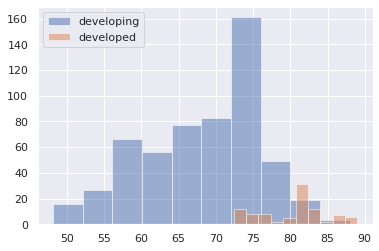

DescribeResult(nobs=557, minmax=(48.1, 88.0), mean=68.31184919210054, variance=62.73744927218009, skewness=-0.4355447299016135, kurtosis=-0.5367958332470311)
DescribeResult(nobs=93, minmax=(72.4, 89.0), mean=80.36236559139783, variance=19.949981299672746, skewness=-0.14462509258543646, kurtosis=-0.7786637954952838)


In [ ]:
#Checking distributions

plt.hist(deving['life_expectancy'], alpha = .5)
plt.hist(deved['life_expectancy'], alpha = .5)
plt.legend(["developing", "developed"], loc ="upper left") 
plt.show()

print(stats.describe(deving['life_expectancy']))
print(stats.describe(deved['life_expectancy']))

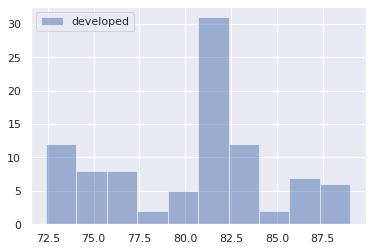

DescribeResult(nobs=93, minmax=(72.4, 89.0), mean=80.36236559139783, variance=19.949981299672746, skewness=-0.14462509258543646, kurtosis=-0.7786637954952838)


In [ ]:
#Getting a closer looked at Developed

plt.hist(deved['life_expectancy'], alpha = .5)
plt.legend(['developed'], loc ='upper left') 
plt.show()

print(stats.describe(deved['life_expectancy']))

In [ ]:
deving[['life_expectancy', 'gdp', 'percentage_expenditure']].describe()

,life_expectancy,gdp,percentage_expenditure
count,557.000000,557.000000,557.000000
mean,68.311849,4071.986523,451.615645
std,7.920698,6563.654484,965.675918
min,48.100000,8.376432,0.108056
25%,62.600000,553.328940,43.573289
50%,69.300000,1574.978653,151.104555
75%,74.500000,4716.673325,509.002041
max,88.000000,52496.694870,9748.636237


In [ ]:
deved[['life_expectancy', 'gdp', 'percentage_expenditure']].describe()

,life_expectancy,gdp,percentage_expenditure
count,93.000000,93.000000,93.000000
mean,80.362366,23092.340929,3100.730248
std,4.466540,25970.876174,4007.785650
min,72.400000,12.277330,1.576409
25%,76.800000,4651.386470,423.680459
50%,81.400000,13467.468270,1230.748231
75%,82.600000,35849.373640,4509.234803
max,89.000000,119172.741800,17028.527980


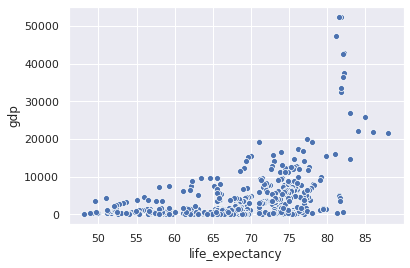

In [ ]:
sns.scatterplot(x="life_expectancy", y="gdp", data=deving )

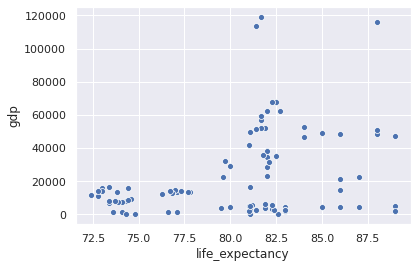

In [ ]:
sns.scatterplot(x="life_expectancy", y="gdp", data=deved );

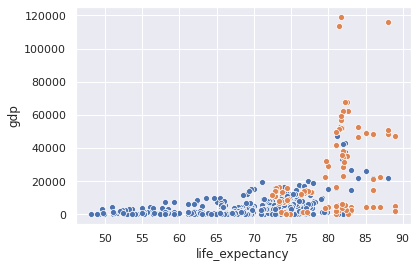

In [ ]:
sns.scatterplot(x="life_expectancy", y="gdp", data=deving );
sns.scatterplot(x="life_expectancy", y="gdp", data=deved );

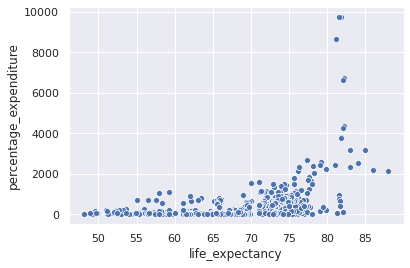

In [ ]:
sns.scatterplot(x="life_expectancy", y="percentage_expenditure", data=deving );

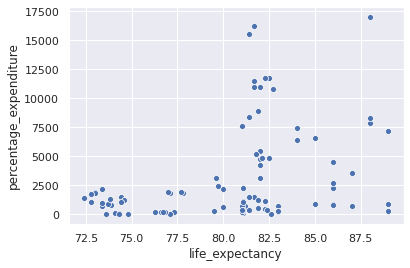

In [ ]:
sns.scatterplot(x="life_expectancy", y="percentage_expenditure", data=deved );

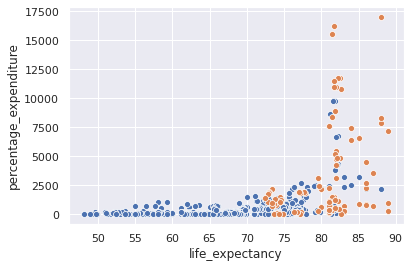

In [ ]:
sns.scatterplot(x="life_expectancy", y="percentage_expenditure", data=deving );
sns.scatterplot(x="life_expectancy", y="percentage_expenditure", data=deved );

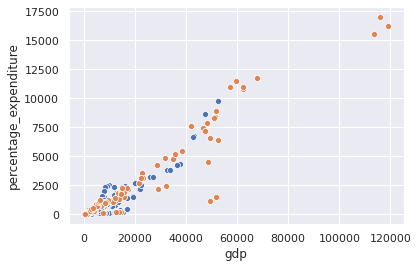

In [ ]:
sns.scatterplot(x="gdp", y="percentage_expenditure", data=deving );
sns.scatterplot(x="gdp", y="percentage_expenditure", data=deved );

In [ ]:
deving[['life_expectancy', 'gdp', 'percentage_expenditure']].corr()

,life_expectancy,gdp,percentage_expenditure
life_expectancy,1.000000,0.469147,0.416950
gdp,0.469147,1.000000,0.920463
percentage_expenditure,0.416950,0.920463,1.000000


In [ ]:
deved[['life_expectancy', 'gdp', 'percentage_expenditure']].corr()

,life_expectancy,gdp,percentage_expenditure
life_expectancy,1.000000,0.333896,0.363697
gdp,0.333896,1.000000,0.938548
percentage_expenditure,0.363697,0.938548,1.000000


In [ ]:
#Filtering for a similar "gdp" range

deving_filtered = deving[deving['gdp'] > 3000]
deving_filtered = deving[deving['gdp'] < 5000]

deved_filtered = deved[deved['gdp'] > 3000]
deved_filtered = deved[deved['gdp'] < 5000]

In [ ]:
print('There are', deving_filtered['country'].count(), 'developed countries.')

There are 422 developed countries.


In [ ]:
print('There are', deved_filtered['country'].count(), 'developed countries.')

There are 28 developed countries.


In [ ]:
#Filtering for a similar "percentage_expenditure" range

deving_filtered = deving[deving['percentage_expenditure'] > 350]
deving_filtered = deving[deving['percentage_expenditure'] < 500]

deved_filtered = deved[deved['percentage_expenditure'] > 350]
deved_filtered = deved[deved['percentage_expenditure'] < 500]

In [ ]:
#Comparing group sizes

ving = len(deving_filtered['life_expectancy'])
ved = len(deved_filtered['life_expectancy'])
tot = ving + ved

print('\"Developing\" sample size:', ving)
print('\"Developed\" sample size:', ved)
print('Test proportion:', ((ving/tot)*(ved/tot)))

"Developing" sample size: 417
"Developed" sample size: 25
Test proportion: 0.05336192952642247


In [ ]:
u_deving = len(deving_filtered['country'].unique())

print('There are', deving_filtered['country'].count(), 'annual samples from developing countries.')
print('There is data from', str(u_deving), 'developing countries.')

There are 417 annual samples from developing countries.
There is data from 110 developing countries.


In [ ]:
u_deved = len(deved_filtered['country'].unique())

print('There are', deved_filtered['country'].count(), 'annual samples from developed countries.')
print('There is data from', str(u_deved), 'developed countries.')

There are 25 annual samples from developed countries.
There is data from 11 developed countries.


In [ ]:
#Taking a look at the distribution of life expectancy for each group

deving_filtered['life_expectancy'].describe()

count    417.000000
mean      66.449880
std        7.628527
min       48.100000
25%       61.100000
50%       67.300000
75%       73.400000
max       82.000000
Name: life_expectancy, dtype: float64

In [ ]:
deved_filtered['life_expectancy'].describe()

count    25.000000
mean     79.056000
std       3.952012
min      73.600000
25%      76.300000
50%      79.500000
75%      82.300000
max      89.000000
Name: life_expectancy, dtype: float64

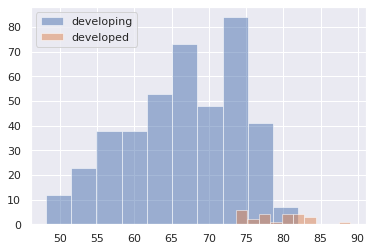

DescribeResult(nobs=417, minmax=(48.1, 82.0), mean=66.44988009592326, variance=58.194429072126916, skewness=-0.3494573068926441, kurtosis=-0.7690813370848413)
DescribeResult(nobs=25, minmax=(73.6, 89.0), mean=79.056, variance=15.618400000000014, skewness=0.38361689752145267, kurtosis=-0.40046494813375055)


In [ ]:
#Checking for normal distributions

plt.hist(deving_filtered['life_expectancy'], alpha = .5)
plt.hist(deved_filtered['life_expectancy'], alpha = .5)
plt.legend(["developing", "developed"], loc ="upper left") 
plt.show()

print(stats.describe(deving_filtered['life_expectancy']))
print(stats.describe(deved_filtered['life_expectancy']))

In [ ]:
print(stats.shapiro(deving_filtered['life_expectancy']))
print(stats.shapiro(deved_filtered['life_expectancy']))

(0.966582179069519, 3.734137266064863e-08)
(0.9155148267745972, 0.04053404554724693)


In [ ]:
#Checking for statistical significance

stats.kruskal(deving_filtered['life_expectancy'], deved_filtered['life_expectancy'])

KruskalResult(statistic=54.47178571516259, pvalue=1.5769573858136749e-13)

## 5. Results

Based on a visual inspection, it appeared as if life expectancy for developing countries, at least, was somewhat normal. However, the shapiro tests showed that neither distribution was normal. For that reason, I used the Kruskal-Wallis test, which showed that there. Based on a very small p-value, I rejected the null hypothesis that both shared the same distribution.

Being that the distributions were not normal, and being that the sample size was sufficiently large, no 95% confidence interval was calculated.


## 6. Discussion and Recommendation

A difference of five to eight years in life expectancy is signifcant. It is worth noting that in order to group for similar GDP and percentage expenditure, samples had to be taken from the upper range in developing and the lower range in developed; meaning that when not adjusted for similar GDP and percentage expenditure, the differences in life span between the two groups only grows.

The difference in ranges was quite striking as well. Selected countries from the developing world had a life expectancy that ranged from 55 to 88, while that range for the developed world was a much tighter 71 to 89 with the 25, 50 and 75 percentiles all within a few year range of 79.15 to 82.76.

Since economics and health often go hand in hand, it is recommended that the developed world starts giving back more in the interest of a global system of fair economics and fair trade where we can all benefit.

A good place to start would be helping to build stable economies and effective healthcare systems in the developing world instead of using them as fuel for capitalistic consumerism.

